In [0]:
# Specify path
input_path = '/content/gdrive/My Drive/hda_dataset_camera02'

# Specify image dimensions
img_height = 480
img_width = 640

# Here we use Google Colab and mount a Google Drive. 
from google.colab import drive
drive.mount('/content/gdrive')

import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install opencv-contrib-python

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [0]:
import re
import cv2

with open(input_path + '/cam02_edited2.txt') as f:
  text = f.read()

str_list = text.split()
start_list = []
end_list = []
for s in str_list:
  if bool(re.match(r'str=[0-9]+',s)):
    temp_str = s.split('=')
    start = temp_str[1]
    start_list.append(start)
  if bool(re.match(r'end=[0-9]+',s)):
    temp_str = s.split('=')
    end = temp_str[1]
    end_list.append(end)

start_list = [int(frame) for frame in start_list]
end_list = [int(frame) for frame in end_list]

cap = cv2.VideoCapture(input_path + '/camera02.avi')
i=0
write_flag = False
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i in start_list:
      write_flag += 1
    if write_flag > 0:
      cv2.imwrite(input_path + '/frame_'+str(i)+'.jpg',frame)
    if i in end_list:
      write_flag -= 1
    i+=1
cap.release()  

In [0]:
# First clean up any existing files.
# This is necessary because later we append to files rather than writing them from scratch.
import os
for i in range(9500):
  if os.path.exists('/content/gdrive/My Drive/hda_dataset_camera02/frame_{}.txt'.format(i)):
    os.remove('/content/gdrive/My Drive/hda_dataset_camera02/frame_{}.txt'.format(i))

# Now parse all the bounding boxes and write them in YOLO retraining input format.
left_list = []
top_list = []
width_list = []
height_list = []
bbox_flag = False
cycle_counter = 0
person_counter = 0
for s in str_list:
  if bool(re.match(r'=\[[0-9.]+',s)):
    left_list.append(s.split('[')[1])
    bbox_flag = True
    cycle_counter = 1
    continue
  if bool(re.match(r'\]',s)):
    bbox_flag = False
    for i in range(end_list[person_counter] - start_list[person_counter] + 1):
      with open(input_path + '/frame_' + str(start_list[person_counter] + i) + '.txt', 'a') as filehandle:
        left = float(left_list.pop(0))
        top = float(top_list.pop(0))
        width = float(width_list.pop(0))
        height = float(height_list.pop(0))

        # YOLO retraining requires bbox centers rather than top left corner.
        x_center = left + width/2
        y_center = top - height/2

        # Normalize
        x_center = x_center / img_width
        y_center = y_center / img_height
        width = width/img_width
        height = height/img_height
        filehandle.write("0 {} {} {} {}\n".format(x_center,y_center,width,height))
    person_counter += 1
    continue
  if bbox_flag:
    if cycle_counter == 0:
      left_list.append(s)
      cycle_counter = 1
      continue
    if cycle_counter == 1:
      top_list.append(s)
      cycle_counter = 2
      continue
    if cycle_counter == 2:
      width_list.append(s)
      cycle_counter = 3
      continue
    if cycle_counter == 3:
      height_list.append(s[:-1])
      cycle_counter = 0
      continue


In [0]:
#!git clone https://github.com/AlexeyAB/darknet # YOLO

%cd darknet/
# Modifications to YOLO configuration so it outputs people only like we want
#!cp '/content/gdrive/My Drive/detector.c' './src/detector.c'
#!cp '/content/gdrive/My Drive/image.c' './src/image.c'

# Compile YOLO with GPU and OpenCV
#!pip install opencv-python # If openCV not installed
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!make
#!wget https://pjreddie.com/media/files/yolov3.weights # Pretrained weights


E:\Downloads\toolbox-master\toolbox-master\darknet


'sed' is not recognized as an internal or external command,
operable program or batch file.
'sed' is not recognized as an internal or external command,
operable program or batch file.
'make' is not recognized as an internal or external command,
operable program or batch file.


In [0]:
# Copy custom configuration files
!cp "/content/gdrive/My Drive/custom_yolo/yolov3-custom.cfg" cfg/
!cp "/content/gdrive/My Drive/custom_yolo/custom.data" build/darknet/x64/data/
!cp "/content/gdrive/My Drive/custom_yolo/custom.names" build/darknet/x64/data/

In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74 build/darknet/x64/yolov3-spp.cfg # Pretrained weights for convolutional part only

--2020-03-23 03:15:12--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   331KB/s    in 10m 47s 

2020-03-23 03:26:01 (245 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]

--2020-03-23 03:26:01--  http://build/darknet/x64/yolov3-spp.cfg
Resolving build (build)... failed: No address associated with hostname.
wget: unable to resolve host address ‘build’
FINISHED --2020-03-23 03:26:01--
Total wall clock time: 10m 49s
Downloaded: 1 files, 155M in 10m 47s (245 KB/s)


In [0]:
# Copy training images/labels to appropriate directory

# Make directory if needed
!mkdir /content/darknet/build/darknet/x64/data/custom

# Copy
%cd "/content/gdrive/My Drive/hda_dataset_camera02/"
!cp *.jpg /content/darknet/build/darknet/x64/data/custom/
!cp *.txt /content/darknet/build/darknet/x64/data/custom/

mkdir: cannot create directory ‘/content/darknet/build/darknet/x64/data/custom’: File exists
/content/gdrive/My Drive/hda_dataset_camera02


In [0]:
import glob
import re

# functions for sorting paths in natural way (using number in the filename)
def int_detector(text):
    return int(text) if text.isdigit() else text
def natural_sorter(text):
    return [ int_detector(c) for c in re.split('(\d+)',text) ]

frame_list = glob.glob('/content/darknet/build/darknet/x64/data/custom/' + '*.jpg')
frame_list.sort(key=natural_sorter)

frame_list = [path.split('/',3)[3] for path in frame_list]


import random
random.seed(43)
train = random.sample(frame_list,int(0.8*len(frame_list)))
test = [x for x in frame_list if x not in train]

with open('build/darknet/x64/data/train.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % path for path in train)
with open('build/darknet/x64/data/test.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % path for path in test)


In [0]:
!./darknet detector train build/darknet/x64/data/custom.data cfg/yolov3-custom.cfg darknet53.conv.74 -map -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.458038, GIOU: 0.324239), Class: 0.926435, Obj: 0.167747, No Obj: 0.000683, .5R: 0.000000, .75R: 0.000000, count: 2, class_loss = 0.476702, iou_loss = 0.865902, total_loss = 1.342604 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000286, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.000034, iou_loss = 0.000000, total_loss = 0.000034 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.524955, GIOU: 0.511425), Class: 0.928428, Obj: 0.149949, No Obj: 0.002086, .5R: 0.750000, .75R: 0.000000, count: 4, class_loss = 0.852155, iou_loss = 0.917421, total_loss = 1.769575 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000428, .5R: 0.000000, .75R: 0.000000, count: 1

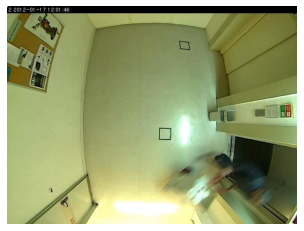

In [0]:
import cv2
import matplotlib.pyplot as plt
import os.path

fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')



frame_number = 1155
file = input_path + '/frame_{}.jpg'.format(frame_number)
file_txt = input_path + '/frame_{}.txt'.format(frame_number)
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

  with open(file_txt, 'r') as filehandle:
    lines = filehandle.readlines()
    for line in lines:
      split_line = line.split()
      left = round(float(split_line[0]))
      top = round(float(split_line[1]))
      width = round(float(split_line[2]))
      height = round(float(split_line[3]))
      
      cv2.rectangle(show_img,(left,top),(left+width,top + height),(0,255,0),2)


  plt.imshow(show_img)

In [0]:
img.shape

(480, 640, 3)